In [1]:
import faiss 
import sys
import os
import math
import random
import heapq 
import time
import numpy as np
import pandas as pd
from PIL import Image
from io import StringIO,BytesIO 
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pywt
from functools import reduce
from sklearn.model_selection import train_test_split

Loading faiss with AVX2 support.


In [2]:
#Baseline:  Wavelet transform.
def FeatureofWavelet(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.resize(img, (128, 128))#resize image 1920x1942
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)  #turn  multi-channel to single-channel
        cA, (cH, cV, cD) = pywt.dwt2(data=img, wavelet='haar')#Single level Discrete Wavelet Transform.
    return cA.flatten()

#1. extracting features
image_dir = '/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New' #the path of images
imgAttrs = [] # features with wf
imgInfos = [] # name and type
trainset = pd.read_csv("/data/fjsdata/ASOCT/Cataract/CBIR_Cataract_ncp_train.csv" , sep=',')#load dataset
print('The length of test set is %d'%trainset.shape[0])
for index, row in trainset.iterrows():#column: name,id,lr,N,C,P  
    if row['name'].endswith(".jpg"):
        try:
            image_path = os.path.join(image_dir, row['name'])
            imgAttrs.append(FeatureofWavelet(image_path))#extracting feature
            imgInfos.append([row['name'], row['id'], row['lr'], row['N'], row['C'], row['P']])
        except:
            print(row['name']+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(imgInfos),trainset.shape[0]))
    sys.stdout.flush()
imgInfos = np.array(imgInfos)

#2. buliding index 
imgAttrs = np.array(imgAttrs).astype('float32') #must be float32
tstart = time.time()
cpu_index = faiss.IndexFlatL2(64*64) #cA is: 64*64
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(imgAttrs) #add data to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))

#3.extracting features of test set
testset = pd.read_csv("/data/fjsdata/ASOCT/Cataract/CBIR_Cataract_ncp_test.csv" , sep=',')#load testset
print('The length of test set is %d'%testset.shape[0])
imgAttrs_test = []# features with wf
imgInfos_test = [] # name and type
for index, row in testset.iterrows():#column: name,id,lr,N,C,P  
    if row['name'].endswith(".jpg"):
        try:
            image_path = os.path.join(image_dir, row['name'])
            imgAttrs_test.append(FeatureofWavelet(image_path))#extracting feature
            imgInfos_test.append([row['name'], row['id'], row['lr'], row['N'], row['C'], row['P']])
        except:
            print(row['name']+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(imgInfos_test),testset.shape[0]))
    sys.stdout.flush()
imgInfos_test = np.array(imgInfos_test) 
imgAttrs_test = np.array(imgAttrs_test).astype('float32') #must be float32


#4.performance
for topk in [5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i in range(imgInfos_test.shape[0]):
        sname, sid, slr, sn, sc, sp  = imgInfos_test[i]
        sid_len = trainset[trainset['id']==sid].shape[0]#numbers of same sid 
        scores, neighbors = gpu_index.search(imgAttrs_test[i:i+1], k=sid_len+topk)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        for j in neighbors.flatten():
            dname, did, dlr, dn, dc, dp = imgInfos[j]
            if sid != did:#not the same id
                if rank_len < topk:
                    rank_len=rank_len+1
                    if ((sn==dn) or (sc==dc) or (sp==dp)) and (slr == dlr):  #hit
                        MHR.append(1)
                        pos_len = pos_len +1
                        MAP.append(pos_len/rank_len) 
                        if mrr_flag==0: 
                            MRR.append(pos_len/rank_len)
                            mrr_flag =1
                    else: 
                        MHR.append(0)
                        MAP.append(0) 
    print("MHR@{}={:.6f}, MAP@{}={:.6f}, MRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

The length of test set is 29304
1349 / 29304 C020_20180514_100234_R_CASIA2_LGC_010.jpg:/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New/C020_20180514_100234_R_CASIA2_LGC_010.jpg
11175 / 29304 C020_20180514_100234_R_CASIA2_LGC_008.jpg:/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New/C020_20180514_100234_R_CASIA2_LGC_008.jpg
11426 / 29304 C020_20180514_100234_R_CASIA2_LGC_002.jpg:/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New/C020_20180514_100234_R_CASIA2_LGC_002.jpg
17059 / 29304 C020_20180514_100234_R_CASIA2_LGC_004.jpg:/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New/C020_20180514_100234_R_CASIA2_LGC_004.jpg
19051 / 29304 C020_20180514_100234_R_CASIA2_LGC_000.jpg:/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New/C020_20180514_100234_R_CASIA2_LGC_000.jpg
19279 / 29304 C020_20180514_100234_R_CASIA2_LGC_016.jpg:/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New/C020_20180514_100234_R_CASIA2_LGC_016.jpg
22192 / 29304 c0151_20181119_110748_L_CASIA2_LGC_030.jpg:/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New/c0151_201

2595
3274


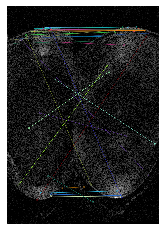

In [18]:
import cv2 
import matplotlib.pyplot as plt

sname, sid, slr, sn, sc, sp  = imgInfos_test[0]
img1_path  = os.path.join(image_dir, sname)
s_cA = FeatureofWavelet(img1_path)
sid_len = trainset[trainset['id']==sid].shape[0]#numbers of same sid 
scores, neighbors = gpu_index.search(s_cA.reshape(1,64*64), k=sid_len+5)
for j in neighbors.flatten():
    dname, did, dlr, dn, dc, dp = imgInfos[j]
    if sid != did:#not the same id
        img2_path  = os.path.join(image_dir, dname)
        break
# read images
img1 = cv2.imread(img1_path)  
img2 = cv2.imread(img2_path) 

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

print (len(keypoints_1))
print (len(keypoints_2))

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)#NORM_L2 is suitble for SIFT,SURF

matches = bf.match(descriptors_1,descriptors_2) 
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:30], img2, flags=2)
plt.imshow(img3)
plt.axis('off')
plt.show()

In [11]:
for topk in [5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i in range(imgInfos_test.shape[0]):
        sname, sid, slr, sn, sc, sp  = imgInfos_test[i]
        sid_len = trainset[trainset['id']==sid].shape[0]#numbers of same sid 
        scores, neighbors = gpu_index.search(imgAttrs_test[i:i+1], k=sid_len+topk)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        for j in neighbors.flatten():
            dname, did, dlr, dn, dc, dp = imgInfos[j]
            if sid != did:#not the same id
                if rank_len < topk:
                    rank_len=rank_len+1
                    if ((sn==dn) or (sc==dc) or (sp==dp)) and (slr == dlr):  #hit
                        MHR.append(1)
                        pos_len = pos_len +1
                        MAP.append(pos_len/rank_len) 
                        if mrr_flag==0: 
                            MRR.append(pos_len/rank_len)
                            mrr_flag =1
                    else: 
                        MHR.append(0)
                        MAP.append(0) 
    print("MHR@{}={:.6f}, MAP@{}={:.6f}, MRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

MHR@5=0.417696, MAP@5=0.366628, MRR@5=0.792186
MHR@10=0.412412, MAP@10=0.333744, MRR@10=0.690930
MHR@15=0.409094, MAP@15=0.312909, MRR@15=0.638783
MHR@20=0.407465, MAP@20=0.297774, MRR@20=0.607514


In [14]:
#split trainset and testset
def value_count(arr):
    arr = np.array(arr)
    key = np.unique(arr)
    result = {}
    for k in key:
        mask = (arr == k)
        arr_new = arr[mask]
        v = arr_new.size
        result[k] = v
    return result

data = pd.read_csv("/data/fjsdata/ASOCT/Cataract/CBIR_Cataract_ncp.csv" , sep=',')#load dataset
print('Dataset Statistics: Rows = %d, Cols = %d' % (data.shape[0], data.shape[1]))
trainset, testset = train_test_split(data, test_size=0.1)
print(trainset.loc[:,'id'].value_counts().shape)
print(testset.loc[:,'id'].value_counts().shape)
trainset.to_csv('/data/fjsdata/ASOCT/Cataract/CBIR_Cataract_ncp_train.csv',index=0)#default sep is ','
print (trainset.shape)
testset.to_csv('/data/fjsdata/ASOCT/Cataract/CBIR_Cataract_ncp_test.csv',index=0)#default sep is ','
print (testset.shape)

Dataset Statistics: Rows = 32560, Cols = 6
(350,)
(341,)
(29304, 6)
(3256, 6)


In [92]:
#N zone
train_n_Path = "/data/fjsdata/ASOCT/Cataract/ncp_label/train_img_level_n.csv" 
train_n = pd.read_csv(train_n_Path, sep=',',header=None,names=['name', 'id','lr','N'])
print (train_n.shape)
test_n_Path = "/data/fjsdata/ASOCT/Cataract/ncp_label/test_img_level_n.csv" 
test_n = pd.read_csv(test_n_Path, sep=',',header=None,names=['name', 'id','lr','N'])
print (test_n.shape)
data_n = pd.concat([train_n, test_n])
data_n['N'].astype(float)
print (data_n.shape)
assert data_n.shape[0] == train_n.shape[0] + test_n.shape[0]
#C zone
train_c_Path = "/data/fjsdata/ASOCT/Cataract/ncp_label/train_img_level_c.csv" 
train_c = pd.read_csv(train_c_Path, sep=',',header=None,names=['name', 'id','lr','C'])
print (train_c.shape)
test_c_Path = "/data/fjsdata/ASOCT/Cataract/ncp_label/test_img_level_c.csv" 
test_c = pd.read_csv(test_c_Path, sep=',',header=None,names=['name', 'id','lr','C'])
print (test_c.shape)
data_c = pd.concat([train_c, test_c])
data_c['C'].astype(float)
print (data_c.shape)
assert data_c.shape[0] == train_c.shape[0] + test_c.shape[0]
#P zone
train_p_Path = "/data/fjsdata/ASOCT/Cataract/ncp_label/train_img_level_p.csv" 
train_p = pd.read_csv(train_p_Path, sep=',',header=None,names=['name', 'id','lr','P'])
print (train_p.shape)
test_p_Path = "/data/fjsdata/ASOCT/Cataract/ncp_label/test_img_level_p.csv" 
test_p = pd.read_csv(test_p_Path, sep=',',header=None,names=['name', 'id','lr','P'])
print (test_p.shape)
data_p = pd.concat([train_p, test_p])
data_p['P'].astype(float)
data_p['P']+=1.0 #keep labels same with N
print (data_p.shape)
assert data_p.shape[0] == train_p.shape[0] + test_p.shape[0]
#join
data =  pd.merge(data_n, pd.merge(data_c, data_p, on=['name','id','lr'], how='outer'), on=['name','id','lr'], how='outer')
data.fillna(0,inplace=True) #fill the Null with zero,denotes no label
print (data.shape)
data.to_csv('/data/fjsdata/ASOCT/Cataract/CBIR_Cataract_ncp.csv',index=0)#default sep is ','
#verfying data
#print(data.loc[:,'N'].value_counts())
#data[data['N'].isnull().values==True]
#print(data.loc[:,'C'].value_counts())
#data[data['C'].isnull().values==True]
#print(data.loc[:,'P'].value_counts())
#data[data['P'].isnull().values==True]
#print(data.loc[:,'lr'].value_counts())

(23366, 4)
(9194, 4)
(32560, 4)
(22719, 4)
(9279, 4)
(31998, 4)
(17086, 4)
(8120, 4)
(25206, 4)
(32560, 6)


In [35]:
#1. extracting features
imgAttrs = [] # features with wf
imgInfos = [] # name and type
data = pd.read_csv("/data/fjsdata/ASOCT/Cataract/CBIR_Cataract.csv" , sep=',')#load dataset
print('Dataset Statistics: Rows = %d, Cols = %d' % (data.shape[0], data.shape[1]))
image_dir = '/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New' #the path of images
for index, row in data.iterrows():
    #column: A-name, B-unkown, C- left or right eye, D- level
    image_path = os.path.join(image_dir, row['A'])
    if row['A'].endswith(".jpg"):
        try:
            img = cv2.imread(image_path)
            if img is not None:
                img = cv2.resize(img, (128, 128))#resize image 1920x1942
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)  #turn  multi-channel to single-channel
                cA, (cH, cV, cD) = pywt.dwt2(data=img, wavelet='haar')#Single level Discrete Wavelet Transform.
                imgAttrs.append(cA.flatten())
                imgInfos.append([row['A'], row['C'], row['D']])
        except:
            print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(imgInfos),31998))
    sys.stdout.flush()
    
#2. buliding index 
imgAttrs = np.array(imgAttrs).astype('float32') #must be float32
tstart = time.time()
cpu_index = faiss.IndexFlatL2(64*64) #cA is: 64*64
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(imgAttrs) #add data to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))

#3.generating testset
imgTest = random.sample(np.arange(len(imgInfos)).tolist(), int(len(imgInfos)*0.1)) #10% for test
print('The length of test set is %d'%len(imgTest))
imgInfos = np.array(imgInfos)

#4.performance
for topk in [5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i in imgTest:
        sname, slr, slevel = imgInfos[i]
        scores, neighbors = gpu_index.search(imgAttrs[i:i+1], k=topk+1)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        for j in neighbors.flatten()[1:]:#remove self
            dname, dlr, dlevel = imgInfos[j]
            rank_len=rank_len+1
            if (slevel==dlevel) and (slr == dlr):  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("MHR@{}={:.6f}, MAP@{}={:.6f}, MRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

Dataset Statistics: Rows = 31998, Cols = 4
31990 / 31998 Completed buliding index in 1 seconds
The length of test set is 3199
MHR@5=0.990560, MAP@5=0.989932, MRR@5=0.999478
MHR@10=0.970553, MAP@10=0.968138, MRR@10=0.999210
MHR@15=0.932666, MAP@15=0.926508, MRR@15=0.999210
MHR@20=0.878509, MAP@20=0.867527, MRR@20=0.999210


In [15]:
def value_count(arr):
    arr = np.array(arr)
    key = np.unique(arr)
    result = {}
    for k in key:
        mask = (arr == k)
        arr_new = arr[mask]
        v = arr_new.size
        result[k] = v
    return result

data = pd.read_csv("/data/fjsdata/ASOCT/Cataract/CBIR_Cataract.csv" , sep=',')#load dataset
print('Dataset Statistics: Rows = %d, Cols = %d' % (data.shape[0], data.shape[1]))
#print(data.loc[:,'B'].value_counts())
print(data.loc[:,'C'].value_counts())
print(data.loc[:,'D'].value_counts())

Dataset Statistics: Rows = 31998, Cols = 4
OD    18560
OS    13438
Name: C, dtype: int64
2.0    10865
3.0     7375
1.0     6311
4.0     3571
2.5     1335
3.5      736
5.0      676
4.5      617
1.5      512
Name: D, dtype: int64
